In [1]:
import os 
import glob
import shutil
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from skimage.io import imread,imsave
from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow.keras.utils import plot_model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import save_model, load_model, Model
from tensorflow.keras.layers import Input,InputLayer, Dropout, Flatten, Dense, Activation, MaxPooling2D, Conv2D
from sklearn.metrics import classification_report

Densenet without augmentation with learning rate 0.0001 and optimizer adam

In [2]:
def densenet201_row(optimizer, loss, metrics, shape):
    image_input = tf.keras.applications.DenseNet201(include_top=False, weights='imagenet', input_shape=shape)

    for layer in image_input.layers:
        layer.trainable = True
        layer._name = layer._name + str('_img')

    y = Flatten()(image_input.output)
    c = Dropout(0.4)(y)
    c = Dense(512)(c)
    c = Dense(256)(c)
    c = Dense(128)(c)
    output_layer = Dense(3, activation='softmax')(c)

    model = Model(inputs=image_input.input, outputs=output_layer)
    model.compile(optimizer=optimizer, loss=loss, metrics=metrics)
    return model

In [3]:
root='/blue/oguzhan/swetha.lenkala/AFFINE_REG_SKS_MASK_2D_IMAGES_DIR'

In [4]:
def plot_confusion_matrix(true_lab,predict_lab,classes,path):
  matrix_confusion = tf.math.confusion_matrix(labels=true_lab, predictions=predicted_lab, num_classes=len(classes))
  ax = plt.subplot()
  sns.heatmap(matrix_confusion, square=True, annot=True, cmap='Blues', fmt='d', cbar=True)
  ax.set_xlabel('Predicted labels')
  ax.set_ylabel('True labels')
  ax.set_title('Confusion Matrix')
  ax.xaxis.set_ticklabels(classes)
  ax.yaxis.set_ticklabels(classes)
  plt.savefig(f'{path}confusion_matrix.png')
     

In [5]:
def dump_text(text,path):
  text_file = open(path, "w")
  text_file.write(text)
  text_file.close()

In [6]:
image_Shape=(436,364,3)
training_image_datagen = ImageDataGenerator(horizontal_flip=True).flow_from_directory(
                                                  directory=f'{root}/training/',
                                                  target_size=(image_Shape[0], image_Shape[1]),
                                                  class_mode='categorical',
                                                  batch_size=4
                                                  )

testing_image_datagen = ImageDataGenerator().flow_from_directory(
                                                  directory = f'{root}/testing/' ,
                                                  target_size = (image_Shape[0] ,image_Shape[1]) ,
                                                  class_mode = 'categorical' ,
                                                  batch_size=1 ,
                                                  shuffle = False
                                                  )

Found 1901 images belonging to 3 classes.
Found 478 images belonging to 3 classes.


In [7]:
EPOCH = 100
METRICS = [
    tf.keras.metrics.CategoricalAccuracy(name='Accuracy'),
    tf.keras.metrics.Precision(name='AD_Precision',class_id=0),
    tf.keras.metrics.Precision(name='CN_Precision',class_id=1),
    tf.keras.metrics.Precision(name='MCI_Precision',class_id=2),
    tf.keras.metrics.Recall(name='AD_Recall',class_id=0),
    tf.keras.metrics.Recall(name='CN_Recall',class_id=1),
    tf.keras.metrics.Recall(name='MCI_Recall',class_id=2),
    ]
LOOS = 'categorical_crossentropy'

2024-04-14 12:28:34.226691: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-04-14 12:28:35.062605: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 9629 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 2080 Ti, pci bus id: 0000:1b:00.0, compute capability: 7.5


In [15]:
savepath = 'models'
lr=0.0001
if not os.path.isdir(savepath):
      os.makedirs(savepath)
csvloger_callback = tf.keras.callbacks.CSVLogger(f'{savepath}history.csv', separator=',', append=False)

modelcheckpoint_callback = tf.keras.callbacks.ModelCheckpoint(savepath+'densenet201_row_10E-5_weights-epoch:{epoch:03d}-val_Accuracy:{val_Accuracy:.4f}.h5',monitor='val_Accuracy'
    ,verbose=0,save_best_only=True,save_weights_only=True,mode='max',save_freq='epoch' , initial_value_threshold=0.85)

OPT = tf.keras.optimizers.Adam(learning_rate=lr)
model03 = densenet201_row(OPT, LOOS,METRICS,image_Shape)
history03 = model03.fit(training_image_datagen, epochs=EPOCH, validation_data=testing_image_datagen,callbacks=[csvloger_callback,modelcheckpoint_callback])
model03 = densenet201_row(OPT, LOOS,METRICS,image_Shape)
model03.load_weights(glob.glob(f"{savepath}densenet201_row_10E-5_weights-epoch:*-val_Accuracy:{max(history03.history['val_Accuracy']):.4f}.h5")[0])

Epoch 1/50
476/476 [==============================] - 121s 194ms/step - loss: 8.7958 - Accuracy: 0.5633 - AD_Precision: 0.3949 - CN_Precision: 0.5183 - MCI_Precision: 0.6351 - AD_Recall: 0.3286 - CN_Recall: 0.4480 - MCI_Recall: 0.6636 - val_loss: 0.9823 - val_Accuracy: 0.5690 - val_AD_Precision: 0.8182 - val_CN_Precision: 0.7222 - val_MCI_Precision: 0.5594 - val_AD_Recall: 0.2967 - val_CN_Recall: 0.0878 - val_MCI_Recall: 0.9456
Epoch 2/50
476/476 [==============================] - 90s 190ms/step - loss: 0.8790 - Accuracy: 0.6691 - AD_Precision: 0.6288 - CN_Precision: 0.6290 - MCI_Precision: 0.7266 - AD_Recall: 0.5000 - CN_Recall: 0.5301 - MCI_Recall: 0.7438 - val_loss: 0.8823 - val_Accuracy: 0.6423 - val_AD_Precision: 0.6111 - val_CN_Precision: 0.8507 - val_MCI_Precision: 0.6452 - val_AD_Recall: 0.2418 - val_CN_Recall: 0.3851 - val_MCI_Recall: 0.9205
Epoch 3/50
476/476 [==============================] - 86s 180ms/step - loss: 0.8654 - Accuracy: 0.7144 - AD_Precision: 0.5952 - CN_Precis

              precision    recall  f1-score   support

          AD       0.92      0.65      0.76        91
          CN       0.82      0.91      0.86       148
         MCI       0.86      0.89      0.87       239

    accuracy                           0.85       478
   macro avg       0.87      0.82      0.83       478
weighted avg       0.86      0.85      0.85       478



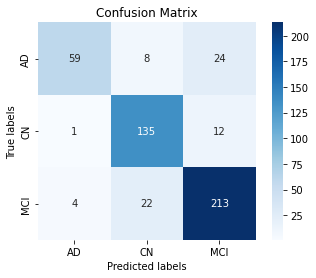

In [16]:
model03.save(f"{savepath}/densenet201_50_0.0001.h5")
p2 = model03.predict(testing_image_datagen)
predicted_lab = p2.argmax(axis=-1)
true_lab = testing_image_datagen.classes
plot_confusion_matrix(true_lab, predicted_lab, testing_image_datagen.class_indices.keys(),savepath)
report = classification_report(true_lab, predicted_lab, target_names=testing_image_datagen.class_indices.keys())
print(report)
dump_text(report,f'{savepath}classification_report.txt')
np.save("densenet201_50_0.0001.npy",p2 )  

Densenet without augmentation with learning rate 0.001 and optimizer adam

Epoch 1/50


2024-03-18 14:53:39.123592: I tensorflow/stream_executor/cuda/cuda_dnn.cc:366] Loaded cuDNN version 8201


476/476 [==============================] - 140s 240ms/step - loss: 23.8305 - Accuracy: 0.4098 - AD_Precision: 0.1839 - CN_Precision: 0.2825 - MCI_Precision: 0.5540 - AD_Recall: 0.1928 - CN_Recall: 0.2951 - MCI_Recall: 0.5304 - val_loss: 5.0204 - val_Accuracy: 0.2280 - val_AD_Precision: 0.1968 - val_CN_Precision: 0.2500 - val_MCI_Precision: 0.4138 - val_AD_Recall: 0.8132 - val_CN_Recall: 0.0676 - val_MCI_Recall: 0.1004
Epoch 2/50
476/476 [==============================] - 101s 213ms/step - loss: 2.3684 - Accuracy: 0.4029 - AD_Precision: 0.1449 - CN_Precision: 0.2402 - MCI_Precision: 0.5390 - AD_Recall: 0.1235 - CN_Recall: 0.1903 - MCI_Recall: 0.5370 - val_loss: 143.2006 - val_Accuracy: 0.4874 - val_AD_Precision: 0.2759 - val_CN_Precision: 0.0000e+00 - val_MCI_Precision: 0.5011 - val_AD_Recall: 0.0879 - val_CN_Recall: 0.0000e+00 - val_MCI_Recall: 0.9414
Epoch 3/50
476/476 [==============================] - 98s 205ms/step - loss: 2.1460 - Accuracy: 0.4156 - AD_Precision: 0.1781 - CN_Preci

/apps/tensorflow/2.7.0/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/apps/tensorflow/2.7.0/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/apps/tensorflow/2.7.0/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


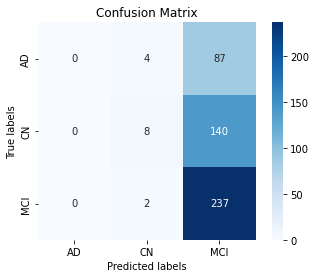

In [9]:
savepath = 'models'
lr=0.001
if not os.path.isdir(savepath):
      os.makedirs(savepath)
csvloger_callback = tf.keras.callbacks.CSVLogger(f'{savepath}history.csv', separator=',', append=False)

modelcheckpoint_callback = tf.keras.callbacks.ModelCheckpoint(savepath+'densenet201_row_10E-5_weights-epoch:{epoch:03d}-val_Accuracy:{val_Accuracy:.4f}.h5',monitor='val_Accuracy'
    ,verbose=0,save_best_only=True,save_weights_only=True,mode='max',save_freq='epoch' , initial_value_threshold=0.85)

OPT = tf.keras.optimizers.Adam(learning_rate=lr)
model03 = densenet201_row(OPT, LOOS,METRICS,image_Shape)
history03 = model03.fit(training_image_datagen, epochs=EPOCH, validation_data=testing_image_datagen,callbacks=[csvloger_callback,modelcheckpoint_callback])
model03 = densenet201_row(OPT, LOOS,METRICS,image_Shape)
model03.load_weights(glob.glob(f"{savepath}densenet201_row_10E-5_weights-epoch:*-val_Accuracy:{max(history03.history['val_Accuracy']):.4f}.h5")[0])
model03.save(f"{savepath}/densenet201_50_0.001.h5")
p2 = model03.predict(testing_image_datagen)
predicted_lab = p2.argmax(axis=-1)
true_lab = testing_image_datagen.classes
plot_confusion_matrix(true_lab, predicted_lab, testing_image_datagen.class_indices.keys(),savepath)
report = classification_report(true_lab, predicted_lab, target_names=testing_image_datagen.class_indices.keys())
print(report)
dump_text(report,f'{savepath}classification_report.txt')
np.save("densenet201_50_0.001.npy",p2 )  

Epoch 1/50


2024-03-18 17:30:38.188641: I tensorflow/stream_executor/cuda/cuda_dnn.cc:366] Loaded cuDNN version 8201


476/476 [==============================] - 124s 210ms/step - loss: 2.2432 - Accuracy: 0.4608 - AD_Precision: 0.2295 - CN_Precision: 0.3755 - MCI_Precision: 0.5748 - AD_Recall: 0.2108 - CN_Recall: 0.3515 - MCI_Recall: 0.5759 - val_loss: 1.6089 - val_Accuracy: 0.5105 - val_AD_Precision: 0.3226 - val_CN_Precision: 0.4872 - val_MCI_Precision: 0.5531 - val_AD_Recall: 0.1099 - val_CN_Recall: 0.3851 - val_MCI_Recall: 0.7197
Epoch 2/50
476/476 [==============================] - 93s 195ms/step - loss: 1.5507 - Accuracy: 0.5734 - AD_Precision: 0.3935 - CN_Precision: 0.4871 - MCI_Precision: 0.6710 - AD_Recall: 0.3675 - CN_Recall: 0.4388 - MCI_Recall: 0.6907 - val_loss: 1.4885 - val_Accuracy: 0.5879 - val_AD_Precision: 0.5185 - val_CN_Precision: 0.6339 - val_MCI_Precision: 0.5810 - val_AD_Recall: 0.1538 - val_CN_Recall: 0.4797 - val_MCI_Recall: 0.7950
Epoch 3/50
476/476 [==============================] - 89s 188ms/step - loss: 1.2657 - Accuracy: 0.6433 - AD_Precision: 0.5541 - CN_Precision: 0.5673

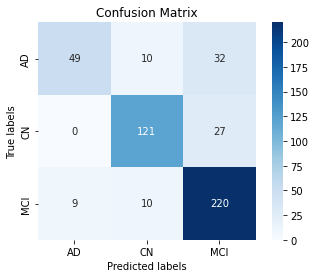

In [8]:
savepath = 'models'
lr=0.000001
if not os.path.isdir(savepath):
      os.makedirs(savepath)
csvloger_callback = tf.keras.callbacks.CSVLogger(f'{savepath}history.csv', separator=',', append=False)

modelcheckpoint_callback = tf.keras.callbacks.ModelCheckpoint(savepath+'densenet201_row_10E-5_weights-epoch:{epoch:03d}-val_Accuracy:{val_Accuracy:.4f}.h5',monitor='val_Accuracy'
    ,verbose=0,save_best_only=True,save_weights_only=True,mode='max',save_freq='epoch' , initial_value_threshold=0.85)

OPT = tf.keras.optimizers.Adam(learning_rate=lr)
model03 = densenet201_row(OPT, LOOS,METRICS,image_Shape)
history03 = model03.fit(training_image_datagen, epochs=EPOCH, validation_data=testing_image_datagen,callbacks=[csvloger_callback,modelcheckpoint_callback])
model03 = densenet201_row(OPT, LOOS,METRICS,image_Shape)
model03.load_weights(glob.glob(f"{savepath}densenet201_row_10E-5_weights-epoch:*-val_Accuracy:{max(history03.history['val_Accuracy']):.4f}.h5")[0])
model03.save(f"{savepath}/densenet201_50_0.0000o1.h5")
p2 = model03.predict(testing_image_datagen)
predicted_lab = p2.argmax(axis=-1)
true_lab = testing_image_datagen.classes
plot_confusion_matrix(true_lab, predicted_lab, testing_image_datagen.class_indices.keys(),savepath)
report = classification_report(true_lab, predicted_lab, target_names=testing_image_datagen.class_indices.keys())
print(report)
dump_text(report,f'{savepath}classification_report.txt')
np.save("densenet201_50_0.000001.npy",p2 )  

Epoch 1/50


2024-03-19 09:33:37.907385: I tensorflow/stream_executor/cuda/cuda_dnn.cc:366] Loaded cuDNN version 8201


476/476 [==============================] - 136s 225ms/step - loss: 10.1210 - Accuracy: 0.4235 - AD_Precision: 0.2061 - CN_Precision: 0.2729 - MCI_Precision: 0.5468 - AD_Recall: 0.1837 - CN_Recall: 0.2485 - MCI_Recall: 0.5266 - val_loss: 4.0183 - val_Accuracy: 0.3452 - val_AD_Precision: 0.2026 - val_CN_Precision: 0.4167 - val_MCI_Precision: 0.4900 - val_AD_Recall: 0.5165 - val_CN_Recall: 0.0338 - val_MCI_Recall: 0.4100
Epoch 2/50
476/476 [==============================] - 96s 203ms/step - loss: 1.9917 - Accuracy: 0.4129 - AD_Precision: 0.1699 - CN_Precision: 0.2804 - MCI_Precision: 0.5534 - AD_Recall: 0.1325 - CN_Recall: 0.2330 - MCI_Recall: 0.5256 - val_loss: 1.8280 - val_Accuracy: 0.4874 - val_AD_Precision: 0.3333 - val_CN_Precision: 0.0000e+00 - val_MCI_Precision: 0.4945 - val_AD_Recall: 0.0769 - val_CN_Recall: 0.0000e+00 - val_MCI_Recall: 0.9456
Epoch 3/50
476/476 [==============================] - 96s 201ms/step - loss: 1.8457 - Accuracy: 0.4166 - AD_Precision: 0.1174 - CN_Precisio

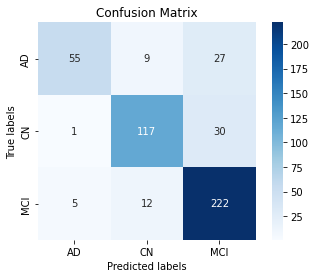

In [8]:
savepath = 'models'
lr=0.0001
if not os.path.isdir(savepath):
      os.makedirs(savepath)
csvloger_callback = tf.keras.callbacks.CSVLogger(f'{savepath}history.csv', separator=',', append=False)

modelcheckpoint_callback = tf.keras.callbacks.ModelCheckpoint(savepath+'densenet201_row_10E-5_weights-epoch:{epoch:03d}-val_Accuracy:{val_Accuracy:.4f}.h5',monitor='val_Accuracy'
    ,verbose=0,save_best_only=True,save_weights_only=True,mode='max',save_freq='epoch' , initial_value_threshold=0.85)

OPT = tf.keras.optimizers.RMSprop(learning_rate=lr)
model03 = densenet201_row(OPT, LOOS,METRICS,image_Shape)
history03 = model03.fit(training_image_datagen, epochs=EPOCH, validation_data=testing_image_datagen,callbacks=[csvloger_callback,modelcheckpoint_callback])
model03 = densenet201_row(OPT, LOOS,METRICS,image_Shape)
model03.load_weights(glob.glob(f"{savepath}densenet201_row_10E-5_weights-epoch:*-val_Accuracy:{max(history03.history['val_Accuracy']):.4f}.h5")[0])
model03.save(f"{savepath}/densenet201_50_0.0001.h5")
p2 = model03.predict(testing_image_datagen)
predicted_lab = p2.argmax(axis=-1)
true_lab = testing_image_datagen.classes
plot_confusion_matrix(true_lab, predicted_lab, testing_image_datagen.class_indices.keys(),savepath)
report = classification_report(true_lab, predicted_lab, target_names=testing_image_datagen.class_indices.keys())
print(report)
dump_text(report,f'{savepath}classification_report.txt')
np.save("densenet201_50_0.0001.npy",p2 )  

Epoch 1/50
476/476 [==============================] - 119s 202ms/step - loss: 4.9874 - Accuracy: 0.5237 - AD_Precision: 0.3150 - CN_Precision: 0.4726 - MCI_Precision: 0.6418 - AD_Recall: 0.3924 - CN_Recall: 0.4555 - MCI_Recall: 0.5986 - val_loss: 2.1280 - val_Accuracy: 0.5397 - val_AD_Precision: 0.3256 - val_CN_Precision: 0.7966 - val_MCI_Precision: 0.6375 - val_AD_Recall: 0.6154 - val_CN_Recall: 0.3176 - val_MCI_Recall: 0.6402
Epoch 2/50
476/476 [==============================] - 94s 197ms/step - loss: 2.6038 - Accuracy: 0.6349 - AD_Precision: 0.4802 - CN_Precision: 0.5700 - MCI_Precision: 0.7186 - AD_Recall: 0.4759 - CN_Recall: 0.5534 - MCI_Recall: 0.7220 - val_loss: 2.9687 - val_Accuracy: 0.6234 - val_AD_Precision: 0.7000 - val_CN_Precision: 0.9231 - val_MCI_Precision: 0.5783 - val_AD_Recall: 0.2308 - val_CN_Recall: 0.3243 - val_MCI_Recall: 0.9582
Epoch 3/50
476/476 [==============================] - 94s 197ms/step - loss: 1.7575 - Accuracy: 0.7165 - AD_Precision: 0.6091 - CN_Precis

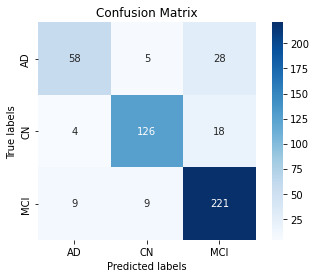

In [9]:
savepath = 'models'
lr=0.00001
if not os.path.isdir(savepath):
      os.makedirs(savepath)
csvloger_callback = tf.keras.callbacks.CSVLogger(f'{savepath}history.csv', separator=',', append=False)

modelcheckpoint_callback = tf.keras.callbacks.ModelCheckpoint(savepath+'densenet201_row_10E-5_weights-epoch:{epoch:03d}-val_Accuracy:{val_Accuracy:.4f}.h5',monitor='val_Accuracy'
    ,verbose=0,save_best_only=True,save_weights_only=True,mode='max',save_freq='epoch' , initial_value_threshold=0.85)

OPT = tf.keras.optimizers.RMSprop(learning_rate=lr)
model03 = densenet201_row(OPT, LOOS,METRICS,image_Shape)
history03 = model03.fit(training_image_datagen, epochs=EPOCH, validation_data=testing_image_datagen,callbacks=[csvloger_callback,modelcheckpoint_callback])
model03 = densenet201_row(OPT, LOOS,METRICS,image_Shape)
model03.load_weights(glob.glob(f"{savepath}densenet201_row_10E-5_weights-epoch:*-val_Accuracy:{max(history03.history['val_Accuracy']):.4f}.h5")[0])
model03.save(f"{savepath}/densenet201_50_0.00001.h5")
p2 = model03.predict(testing_image_datagen)
predicted_lab = p2.argmax(axis=-1)
true_lab = testing_image_datagen.classes
plot_confusion_matrix(true_lab, predicted_lab, testing_image_datagen.class_indices.keys(),savepath)
report = classification_report(true_lab, predicted_lab, target_names=testing_image_datagen.class_indices.keys())
print(report)
dump_text(report,f'{savepath}classification_report.txt')
np.save("densenet201_50_0.00001.npy",p2 )  

Epoch 1/50


2024-03-19 17:09:26.656316: I tensorflow/stream_executor/cuda/cuda_dnn.cc:366] Loaded cuDNN version 8201


476/476 [==============================] - 127s 208ms/step - loss: 2.1405 - Accuracy: 0.4534 - AD_Precision: 0.2595 - CN_Precision: 0.3175 - MCI_Precision: 0.5619 - AD_Recall: 0.2259 - CN_Recall: 0.2854 - MCI_Recall: 0.5769 - val_loss: 1.6613 - val_Accuracy: 0.5251 - val_AD_Precision: 0.3651 - val_CN_Precision: 0.6579 - val_MCI_Precision: 0.5552 - val_AD_Recall: 0.2527 - val_CN_Recall: 0.1689 - val_MCI_Recall: 0.8201
Epoch 2/50
476/476 [==============================] - 97s 203ms/step - loss: 1.6050 - Accuracy: 0.5481 - AD_Precision: 0.3915 - CN_Precision: 0.4509 - MCI_Precision: 0.6407 - AD_Recall: 0.3313 - CN_Recall: 0.4097 - MCI_Recall: 0.6632 - val_loss: 1.2922 - val_Accuracy: 0.5837 - val_AD_Precision: 0.4107 - val_CN_Precision: 0.6174 - val_MCI_Precision: 0.6250 - val_AD_Recall: 0.2527 - val_CN_Recall: 0.4797 - val_MCI_Recall: 0.7322
Epoch 3/50
476/476 [==============================] - 98s 206ms/step - loss: 1.2865 - Accuracy: 0.6165 - AD_Precision: 0.5085 - CN_Precision: 0.5180

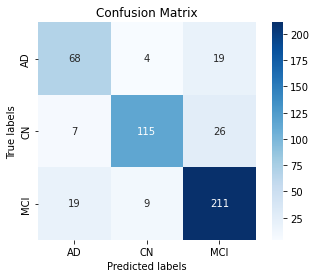

In [8]:
savepath = 'models'
lr=0.000001
if not os.path.isdir(savepath):
      os.makedirs(savepath)
csvloger_callback = tf.keras.callbacks.CSVLogger(f'{savepath}history.csv', separator=',', append=False)

modelcheckpoint_callback = tf.keras.callbacks.ModelCheckpoint(savepath+'densenet201_row_10E-5_weights-epoch:{epoch:03d}-val_Accuracy:{val_Accuracy:.4f}.h5',monitor='val_Accuracy'
    ,verbose=0,save_best_only=True,save_weights_only=True,mode='max',save_freq='epoch' , initial_value_threshold=0.85)

OPT = tf.keras.optimizers.RMSprop(learning_rate=lr)
model03 = densenet201_row(OPT, LOOS,METRICS,image_Shape)
history03 = model03.fit(training_image_datagen, epochs=EPOCH, validation_data=testing_image_datagen,callbacks=[csvloger_callback,modelcheckpoint_callback])
model03 = densenet201_row(OPT, LOOS,METRICS,image_Shape)
model03.load_weights(glob.glob(f"{savepath}densenet201_row_10E-5_weights-epoch:*-val_Accuracy:{max(history03.history['val_Accuracy']):.4f}.h5")[0])
model03.save(f"{savepath}/densenet201_50_0.000001.h5")
p2 = model03.predict(testing_image_datagen)
predicted_lab = p2.argmax(axis=-1)
true_lab = testing_image_datagen.classes
plot_confusion_matrix(true_lab, predicted_lab, testing_image_datagen.class_indices.keys(),savepath)
report = classification_report(true_lab, predicted_lab, target_names=testing_image_datagen.class_indices.keys())
print(report)
dump_text(report,f'{savepath}classification_report.txt')
np.save("densenet201_50_0.000001.npy",p2 )  

In [ ]:
config = tf.compat.v1.ConfigProto()
config.gpu_options.allow_growth = True
session = tf.compat.v1.Session(config=config)

Epoch 1/70


2024-04-13 18:28:29.494717: I tensorflow/stream_executor/cuda/cuda_dnn.cc:366] Loaded cuDNN version 8201


476/476 [==============================] - 123s 210ms/step - loss: 6.9313 - Accuracy: 0.4819 - AD_Precision: 0.2500 - CN_Precision: 0.3543 - MCI_Precision: 0.5738 - AD_Recall: 0.1717 - CN_Recall: 0.2738 - MCI_Recall: 0.6015 - val_loss: 0.9551 - val_Accuracy: 0.5293 - val_AD_Precision: 0.4756 - val_CN_Precision: 0.9333 - val_MCI_Precision: 0.6172 - val_AD_Recall: 0.4286 - val_CN_Recall: 0.0946 - val_MCI_Recall: 0.6611
Epoch 2/70
476/476 [==============================] - 92s 194ms/step - loss: 0.8394 - Accuracy: 0.6360 - AD_Precision: 0.5586 - CN_Precision: 0.6482 - MCI_Precision: 0.6829 - AD_Recall: 0.3735 - CN_Recall: 0.5223 - MCI_Recall: 0.7068 - val_loss: 1.8365 - val_Accuracy: 0.3787 - val_AD_Precision: 0.8000 - val_CN_Precision: 0.3434 - val_MCI_Precision: 0.9412 - val_AD_Recall: 0.0879 - val_CN_Recall: 1.0000 - val_MCI_Recall: 0.0669
Epoch 3/70
476/476 [==============================] - 91s 192ms/step - loss: 0.9539 - Accuracy: 0.6502 - AD_Precision: 0.5271 - CN_Precision: 0.6345

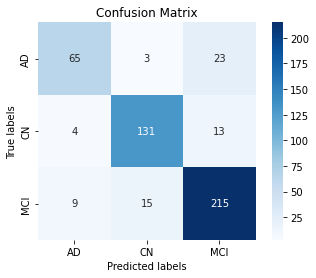

In [8]:
savepath = 'Finetuning/Densenet/Densenet_70_0.0001/'
lr=0.0001
if not os.path.isdir(savepath):
      os.makedirs(savepath)
csvloger_callback = tf.keras.callbacks.CSVLogger(f'{savepath}history.csv', separator=',', append=False)

modelcheckpoint_callback = tf.keras.callbacks.ModelCheckpoint(savepath+'densenet201_row_10E-5_weights-epoch:{epoch:03d}-val_Accuracy:{val_Accuracy:.4f}.h5',monitor='val_Accuracy'
    ,verbose=0,save_best_only=True,save_weights_only=True,mode='max',save_freq='epoch' , initial_value_threshold=0.85)

OPT = tf.keras.optimizers.Adam(learning_rate=lr)
model03 = densenet201_row(OPT, LOOS,METRICS,image_Shape)
history03 = model03.fit(training_image_datagen, epochs=EPOCH, validation_data=testing_image_datagen,callbacks=[csvloger_callback,modelcheckpoint_callback])
model03 = densenet201_row(OPT, LOOS,METRICS,image_Shape)
model03.load_weights(glob.glob(f"{savepath}densenet201_row_10E-5_weights-epoch:*-val_Accuracy:{max(history03.history['val_Accuracy']):.4f}.h5")[0])
model03.save(f"{savepath}/densenet201_50_0.0001.h5")
p2 = model03.predict(testing_image_datagen)
predicted_lab = p2.argmax(axis=-1)
true_lab = testing_image_datagen.classes
plot_confusion_matrix(true_lab, predicted_lab, testing_image_datagen.class_indices.keys(),savepath)
report = classification_report(true_lab, predicted_lab, target_names=testing_image_datagen.class_indices.keys())
print(report)
dump_text(report,f'{savepath}classification_report.txt')
np.save("densenet201_50_0.0001.npy",p2 )  

Epoch 1/100


2024-04-14 12:29:15.643596: I tensorflow/stream_executor/cuda/cuda_dnn.cc:366] Loaded cuDNN version 8201


476/476 [==============================] - 124s 213ms/step - loss: 6.3394 - Accuracy: 0.5018 - AD_Precision: 0.3109 - CN_Precision: 0.3934 - MCI_Precision: 0.6048 - AD_Recall: 0.2500 - CN_Recall: 0.3476 - MCI_Recall: 0.6186 - val_loss: 1.2050 - val_Accuracy: 0.5544 - val_AD_Precision: 0.6170 - val_CN_Precision: 1.0000 - val_MCI_Precision: 0.5725 - val_AD_Recall: 0.3187 - val_CN_Recall: 0.0068 - val_MCI_Recall: 0.9414
Epoch 2/100
476/476 [==============================] - 96s 201ms/step - loss: 0.8324 - Accuracy: 0.6781 - AD_Precision: 0.6322 - CN_Precision: 0.6489 - MCI_Precision: 0.7235 - AD_Recall: 0.4608 - CN_Recall: 0.5670 - MCI_Recall: 0.7524 - val_loss: 0.7471 - val_Accuracy: 0.7029 - val_AD_Precision: 0.8529 - val_CN_Precision: 0.8438 - val_MCI_Precision: 0.6697 - val_AD_Recall: 0.3187 - val_CN_Recall: 0.5473 - val_MCI_Recall: 0.9331
Epoch 3/100
476/476 [==============================] - 93s 195ms/step - loss: 1.0501 - Accuracy: 0.6691 - AD_Precision: 0.5270 - CN_Precision: 0.62

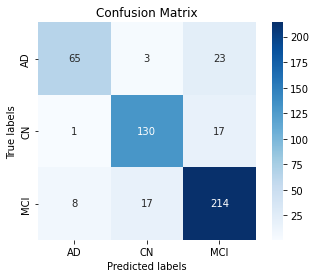

In [8]:
savepath = 'Finetuning/Densenet/Densenet _100_0.0001/'
lr=0.0001
if not os.path.isdir(savepath):
      os.makedirs(savepath)
csvloger_callback = tf.keras.callbacks.CSVLogger(f'{savepath}history.csv', separator=',', append=False)

modelcheckpoint_callback = tf.keras.callbacks.ModelCheckpoint(savepath+'densenet201_row_10E-5_weights-epoch:{epoch:03d}-val_Accuracy:{val_Accuracy:.4f}.h5',monitor='val_Accuracy'
    ,verbose=0,save_best_only=True,save_weights_only=True,mode='max',save_freq='epoch' , initial_value_threshold=0.85)

OPT = tf.keras.optimizers.Adam(learning_rate=lr)
model03 = densenet201_row(OPT, LOOS,METRICS,image_Shape)
history03 = model03.fit(training_image_datagen, epochs=EPOCH, validation_data=testing_image_datagen,callbacks=[csvloger_callback,modelcheckpoint_callback])
model03 = densenet201_row(OPT, LOOS,METRICS,image_Shape)
model03.load_weights(glob.glob(f"{savepath}densenet201_row_10E-5_weights-epoch:*-val_Accuracy:{max(history03.history['val_Accuracy']):.4f}.h5")[0])
model03.save(f"{savepath}/densenet201_100_0.0001.h5")
p2 = model03.predict(testing_image_datagen)
predicted_lab = p2.argmax(axis=-1)
true_lab = testing_image_datagen.classes
plot_confusion_matrix(true_lab, predicted_lab, testing_image_datagen.class_indices.keys(),savepath)
report = classification_report(true_lab, predicted_lab, target_names=testing_image_datagen.class_indices.keys())
print(report)
dump_text(report,f'{savepath}classification_report.txt')
np.save("densenet201_100_0.0001.npy",p2 )  